# IMPORT

In [1]:
# !pip install yfinance
# !pip install pandas-ta
# !pip install chart-studio
# !pip install shap

In [2]:
# Importing libraries
#import shap
import tensorflow as tf
import os
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import seaborn as sns
import matplotlib as plt
import pandas as pd
import tensorflow as tf
from dateutil import parser

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
#import shap
from matplotlib import pyplot
import csv
from datetime import datetime
#import keras_tuner

sns.set_style("dark")
plt.style.use("dark_background")
plt.rcParams['figure.facecolor'] = '#151934'
plt.rcParams['axes.facecolor'] = '#151934'
plt.rcParams.update({'axes.facecolor': '#151934'})
sns.set_palette('pastel')
sns.set_context('talk')
import pandas as pd
# Parse dates and set date column to index

import datetime
from datetime import date, time

# Create a function to plot time series data
def plot_time_series(timesteps, values, format='-', start=0, end=None, label=None):
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("DJIA Stock Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

def mean_absolute_scaled_error(y_true, y_pred):
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
  return mae / mae_naive_no_season

def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}


# FILE PATH

In [3]:
file_path = "/content/upload_DJIA_table (1).csv"


df = pd.read_csv(file_path,
                  parse_dates=["Date"],
                  index_col=["Date"],
                   thousands=',') # parse the date column (tell pandas column 1 is a datetime)


#df = pd.read_csv(file_path,
                  #thousands=',') # parse the date column (tell pandas column 1 is a datetime)

df = df[::-1]


In [4]:
df_c =df.tail(3)
df_c

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688
2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234
2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141


In [5]:
df = df[["Open", "High","Low", "Close","Volume", "Adj Close"]]

df['EMA'] = df['Close'].ewm(com=0.5).mean()
df['MA7'] = df['Close'].rolling(window=7).mean() #Close column
#df['MA20'] = df['Price'].rolling(window=20).mean() #Close Column


#Drop NaN Values
df = df.dropna()
df

,Open,High,Low,Close,Volume,Adj Close,EMA,MA7
Date,,,,,,,,
2008-08-18,11659.650391,11690.429688,11434.120117,11479.389648,156290000,11479.389648,11533.371152,11635.331334
2008-08-19,11478.089844,11478.169922,11318.500000,11348.549805,171580000,11348.549805,11410.138138,11580.221261
2008-08-20,11345.940430,11454.150391,11290.580078,11417.429688,144880000,11417.429688,11414.999418,11528.089844
2008-08-21,11415.230469,11476.209961,11315.570312,11430.209961,130020000,11430.209961,11425.139952,11497.767020
2008-08-22,11426.790039,11632.129883,11426.790039,11628.059570,138790000,11628.059570,11560.420461,11511.352679
...,...,...,...,...,...,...,...,...
2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234,17286.702282,17663.235770
2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703,17368.714563,17625.315848
2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688,17586.024646,17609.574498


In [6]:
# Check for null values in the DataFrame
null_values = df.isnull().sum()

# Print the count of null values for each column
print(null_values)


Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
EMA          0
MA7          0
dtype: int64


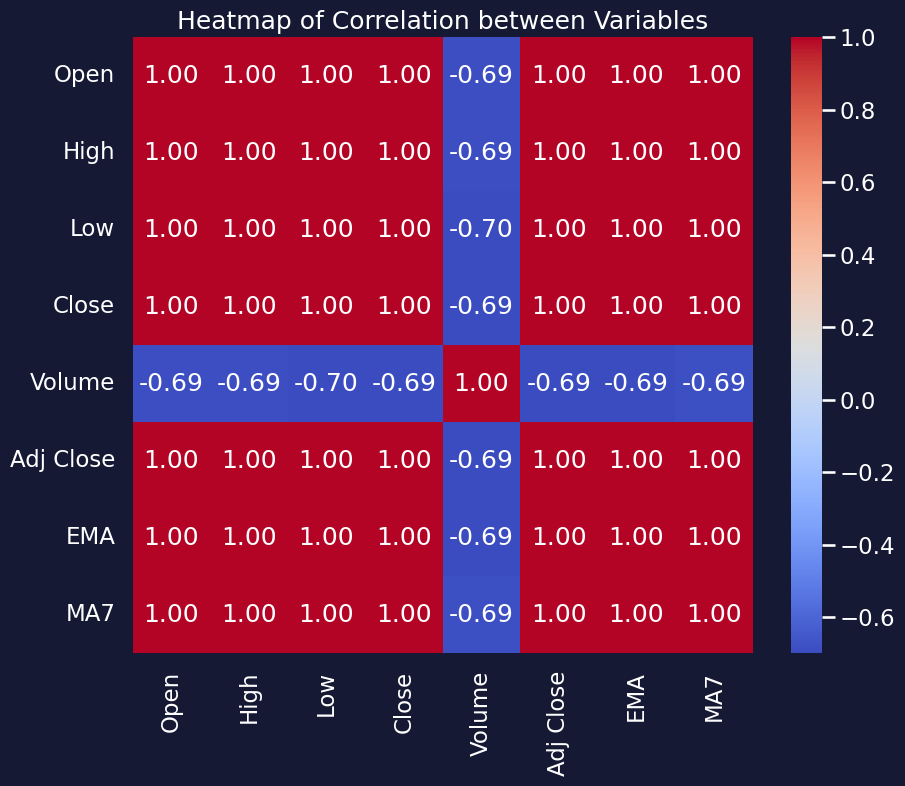

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))  # Adjust the size of the figure as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

# Add a title to the heatmap
plt.title('Heatmap of Correlation between Variables')

# Show the heatmap
plt.show()


In [8]:
# Only want closing price for each day
prices = pd.DataFrame(df["Close"]).rename(columns={"Close": "Price"})
prices.head()

,Price
Date,
2008-08-18,11479.389648
2008-08-19,11348.549805
2008-08-20,11417.429688
2008-08-21,11430.209961
2008-08-22,11628.059570


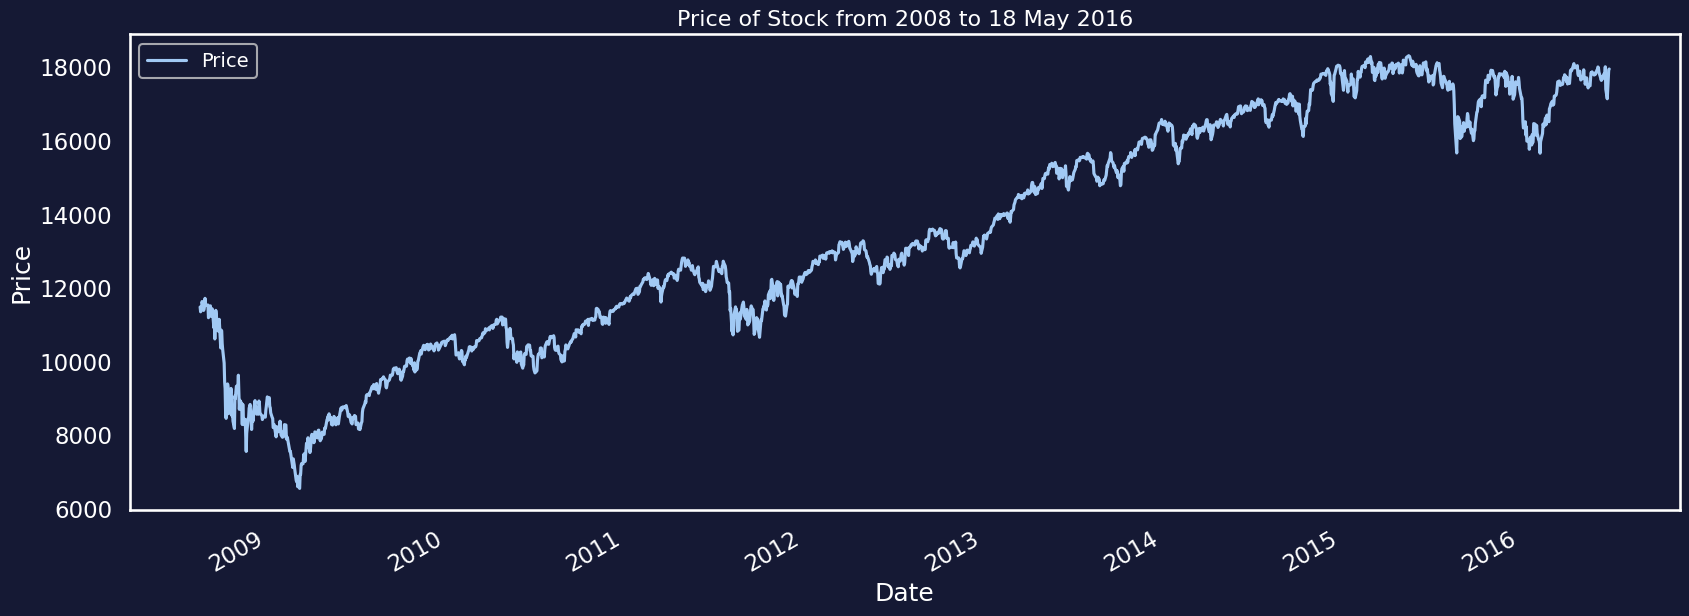

In [9]:
import matplotlib.pyplot as plt
prices.plot(figsize=(20, 7))
plt.ylabel("Price")
plt.title("Price of Stock from 2008 to 18 May 2016", fontsize=16)
plt.legend(fontsize=14);

In [10]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
price = []
with open("/content/upload_DJIA_table (1).csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",") # read in the target CSV
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[0], "%Y-%m-%d")) # get the dates as dates (not strings), strptime = string parse time
    price.append(float(line[4])) # get the closing price as float

# View first 10 of each

timesteps = timesteps[::-1]

price = price[::-1]
timesteps[:10], price[:10]

([datetime.datetime(2008, 8, 8, 0, 0),
  datetime.datetime(2008, 8, 11, 0, 0),
  datetime.datetime(2008, 8, 12, 0, 0),
  datetime.datetime(2008, 8, 13, 0, 0),
  datetime.datetime(2008, 8, 14, 0, 0),
  datetime.datetime(2008, 8, 15, 0, 0),
  datetime.datetime(2008, 8, 18, 0, 0),
  datetime.datetime(2008, 8, 19, 0, 0),
  datetime.datetime(2008, 8, 20, 0, 0),
  datetime.datetime(2008, 8, 21, 0, 0)],
 [11734.320312,
  11782.349609,
  11642.469727,
  11532.959961,
  11615.929688,
  11659.900391,
  11479.389648,
  11348.549805,
  11417.429688,
  11430.209961])

In [11]:
# Get bitcoin date array
timesteps = prices.index.to_numpy()
prices = prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2008-08-18T00:00:00.000000000', '2008-08-19T00:00:00.000000000',
        '2008-08-20T00:00:00.000000000', '2008-08-21T00:00:00.000000000',
        '2008-08-22T00:00:00.000000000', '2008-08-25T00:00:00.000000000',
        '2008-08-26T00:00:00.000000000', '2008-08-27T00:00:00.000000000',
        '2008-08-28T00:00:00.000000000', '2008-08-29T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([11479.389648, 11348.549805, 11417.429688, 11430.209961,
        11628.05957 , 11386.25    , 11412.870117, 11502.509766,
        11715.179688, 11543.959961]))

In [12]:
from sklearn.model_selection import train_test_split


In [13]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(1586, 397, 1586, 397)

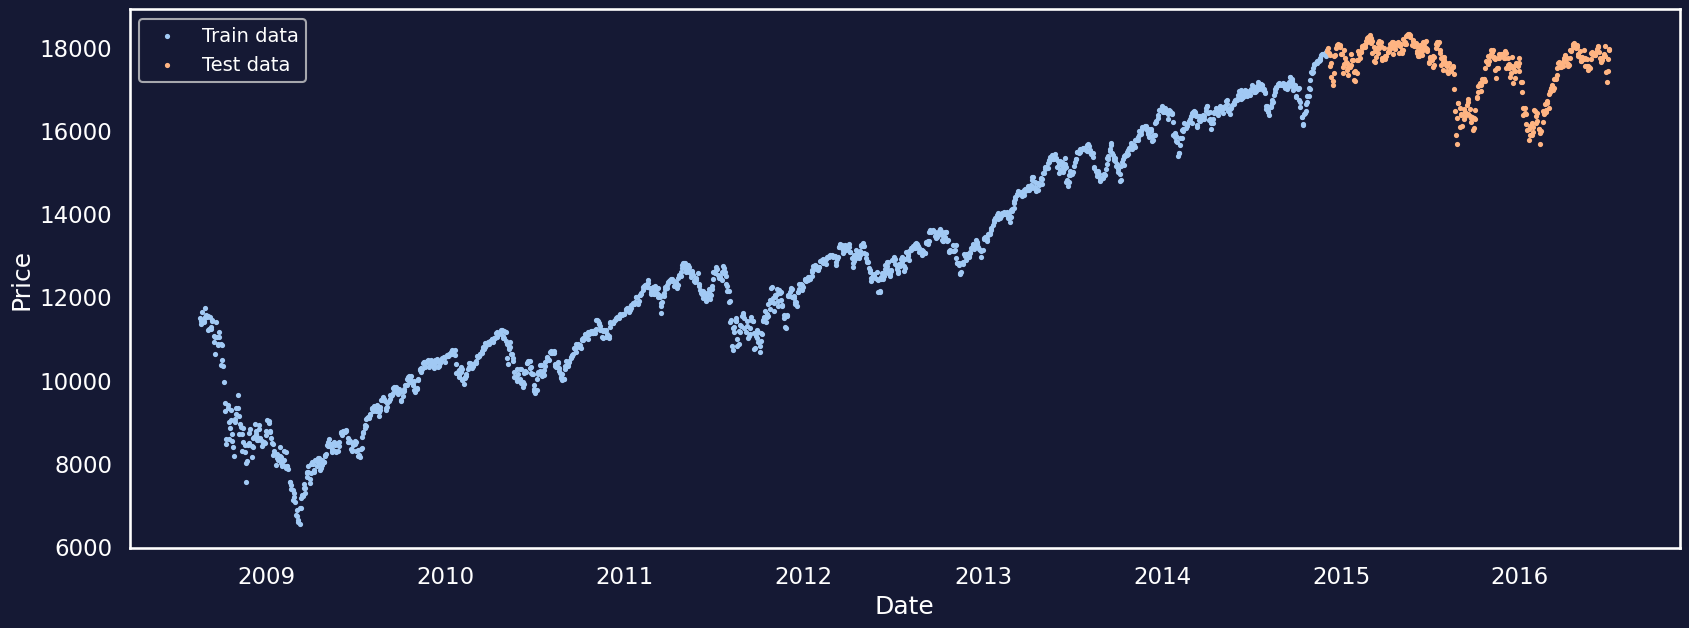

In [14]:
# Plot correctly made splits
plt.figure(figsize=(20, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(fontsize=14)
plt.show();

In [15]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("DJIA Stock Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

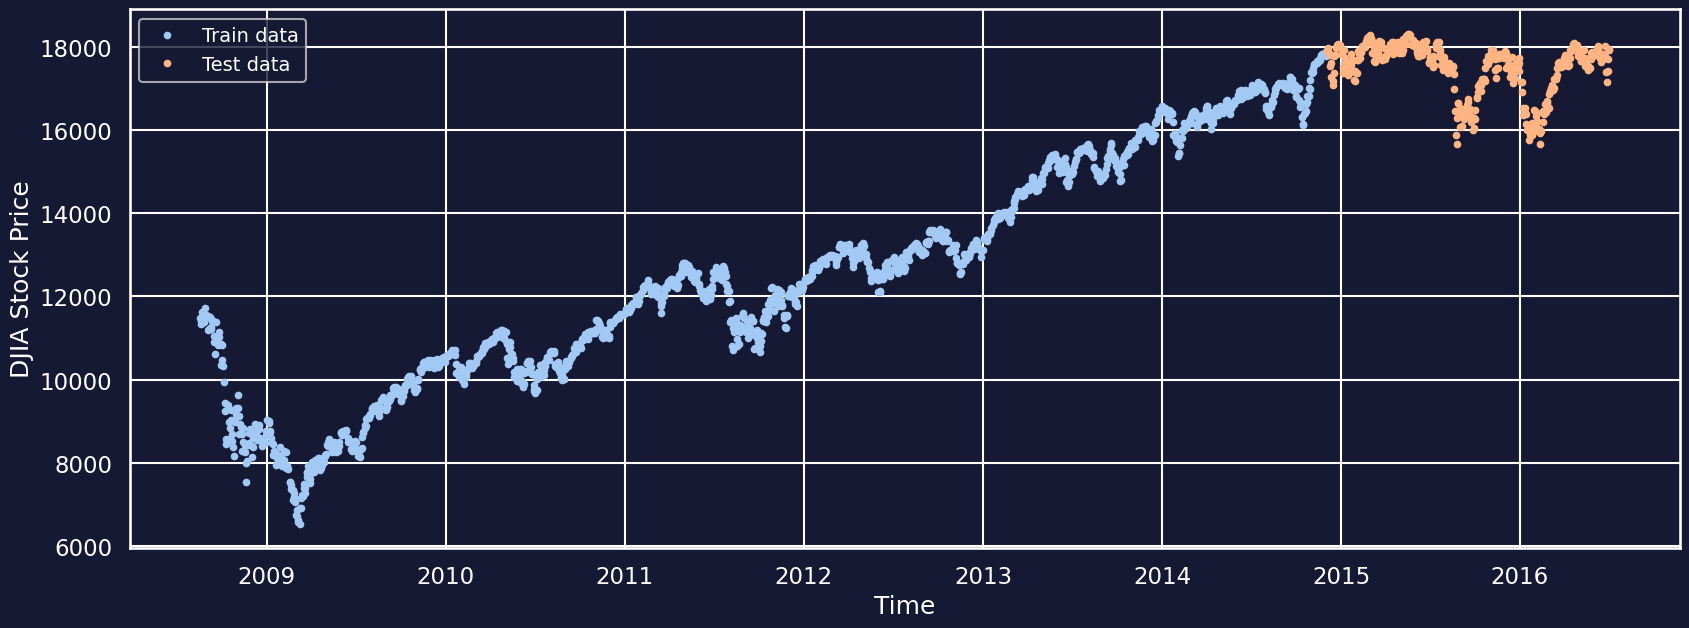

In [16]:
# Try out our plotting function
plt.figure(figsize=(20, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

In [17]:
# Create a naïve forecast
naive_forecast = y_test[:-1] # Naïve forecast equals every value excluding the last value
naive_forecast[:10], naive_forecast[-10:] # View frist 10 and last 10

(array([17900.099609, 17958.789062, 17852.480469, 17801.199219,
        17533.150391, 17596.339844, 17280.830078, 17180.839844,
        17068.869141, 17356.869141]),
 array([17675.160156, 17804.869141, 17829.730469, 17780.830078,
        18011.070312, 17400.75    , 17140.240234, 17409.720703,
        17694.679688, 17929.990234]))

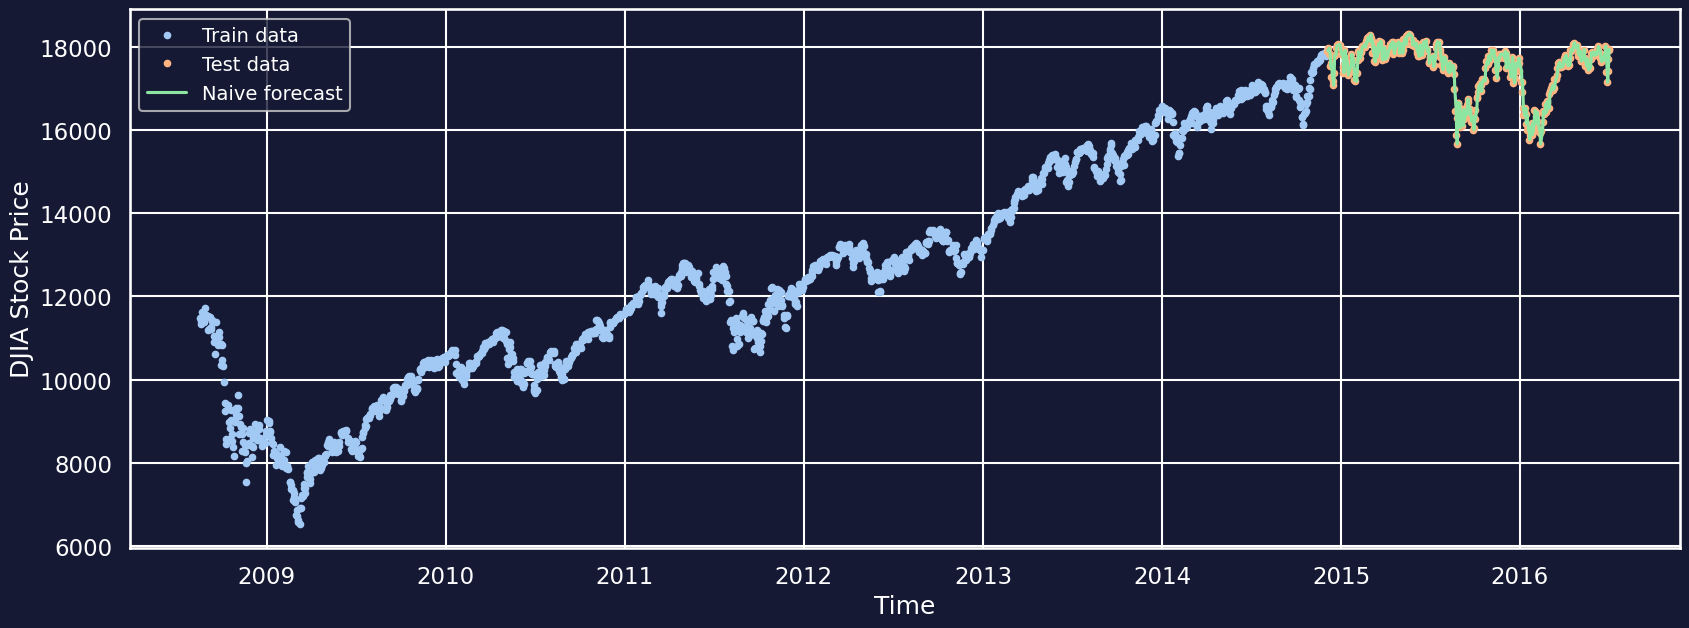

In [18]:
# Plot naive forecast
plt.figure(figsize=(20, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

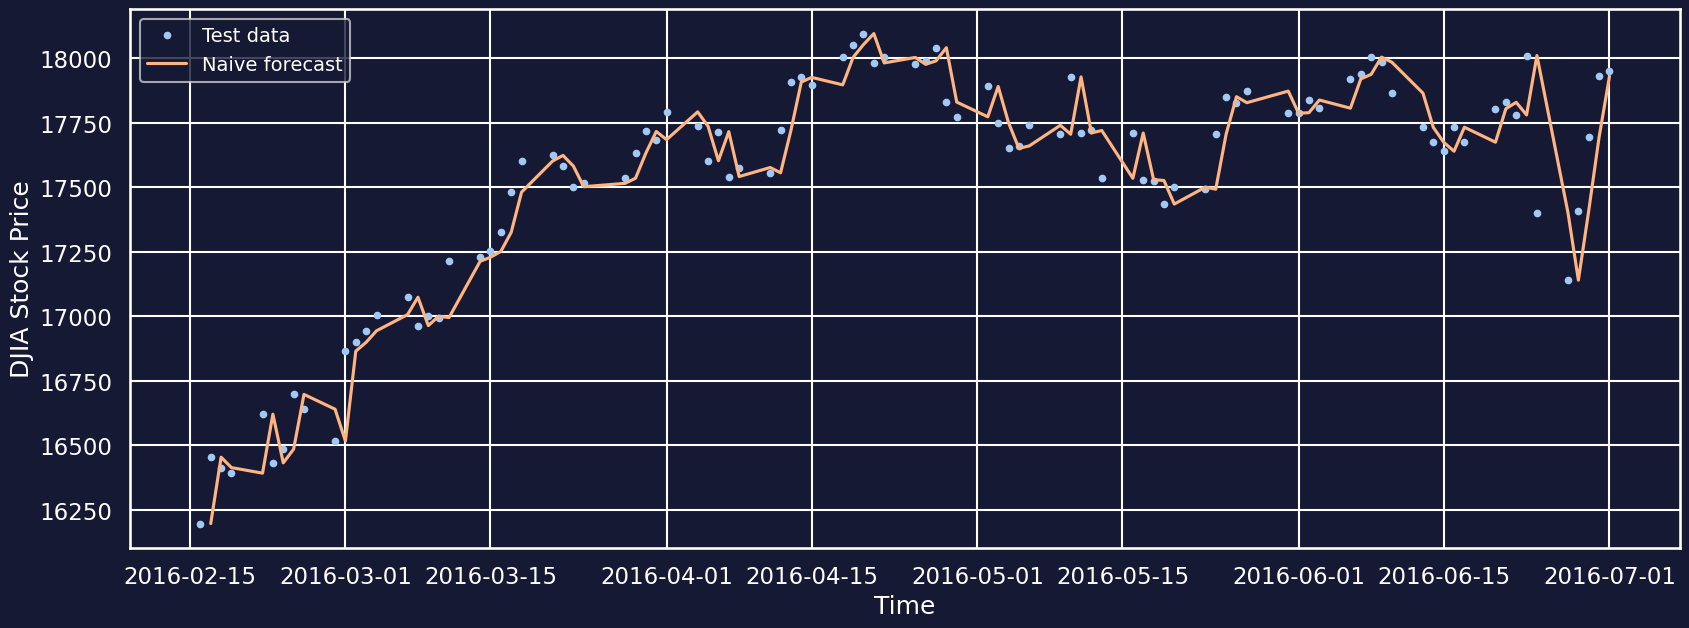

In [19]:
plt.figure(figsize=(20, 7))
offset = 300 # offset the values by 300 timesteps
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

In [20]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 125.68157,
 'mse': 27671.523,
 'rmse': 166.3476,
 'mape': 0.7280941,
 'mase': 0.9986524}

In [21]:
# Find average price in test dataset
tf.reduce_mean(y_test).numpy()

17481.718676214106

In [22]:
df = df[["Open", "High","Low", "Close"]]

df['EMA'] = df['Close'].ewm(com=0.5).mean()
df['MA7'] = df['Close'].rolling(window=7).mean() #Close column
#df['MA20'] = df['Price'].rolling(window=20).mean() #Close Column


#Drop NaN Values
df = df.dropna()
df

,Open,High,Low,Close,EMA,MA7
Date,,,,,,
2008-08-26,11383.559570,11436.240234,11340.410156,11412.870117,11423.249282,11443.251256
2008-08-27,11412.459961,11554.459961,11381.769531,11502.509766,11476.097660,11446.554130
2008-08-28,11499.870117,11715.179688,11499.790039,11715.179688,11635.493777,11498.929827
2008-08-29,11713.230469,11713.230469,11543.389648,11543.959961,11574.470199,11517.005580
2008-09-02,11545.629883,11790.169922,11471.900391,11516.919922,11536.103131,11529.392718
...,...,...,...,...,...,...
2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,17286.702282,17663.235770
2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,17368.714563,17625.315848
2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,17586.024646,17609.574498


In [23]:
df_1 = df
WINDOW_SIZE = 1
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = df_1.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Close+{i+1}"] = bitcoin_prices_windowed["Close"].shift(periods=i+1)
bitcoin_prices_windowed = bitcoin_prices_windowed.dropna()
#bitcoin_prices_windowed[f"c+{-1}"] = bitcoin_prices_windowed["c"].shift(periods=-1)

#Close

bitcoin_prices_windowed[f"Close	+{-1}"] = bitcoin_prices_windowed["Close"].shift(periods=-1)
bitcoin_prices_windowed.rename(columns={'Close\t+-1': 'Close Price'}, inplace=True)

#bitcoin_prices_windowed.rename(columns={'c+-1': 'Close'}, inplace=True)

In [24]:
bitcoin_prices_windowed.head(5)

,Open,High,Low,Close,EMA,MA7,Close+1,Close Price
Date,,,,,,,,
2008-08-27,11412.459961,11554.459961,11381.769531,11502.509766,11476.097660,11446.554130,11412.870117,11715.179688
2008-08-28,11499.870117,11715.179688,11499.790039,11715.179688,11635.493777,11498.929827,11502.509766,11543.959961
2008-08-29,11713.230469,11713.230469,11543.389648,11543.959961,11574.470199,11517.005580,11715.179688,11516.919922
2008-09-02,11545.629883,11790.169922,11471.900391,11516.919922,11536.103131,11529.392718,11543.959961,11532.879883
2008-09-03,11506.009766,11554.379883,11416.530273,11532.879883,11533.954295,11515.795620,11516.919922,11188.230469


In [25]:
bitcoin_prices_windowed.tail(5)

,Open,High,Low,Close,EMA,MA7,Close+1,Close Price
Date,,,,,,,,
2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,17286.702282,17663.235770,17400.750000,17409.720703
2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,17368.714563,17625.315848,17140.240234,17694.679688
2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,17586.024646,17609.574498,17409.720703,17929.990234
2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,17815.335038,17623.897321,17694.679688,17949.369141
2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,17904.691107,17647.974330,17929.990234,NaN


In [26]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors
X = bitcoin_prices_windowed.dropna().drop("Close Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Close Price"].astype(np.float32)
X.head()


,Open,High,Low,Close,EMA,MA7,Close+1
Date,,,,,,,
2008-08-27,11412.459961,11554.459961,11381.769531,11502.509766,11476.097656,11446.553711,11412.870117
2008-08-28,11499.870117,11715.179688,11499.790039,11715.179688,11635.494141,11498.929688,11502.509766
2008-08-29,11713.230469,11713.230469,11543.389648,11543.959961,11574.469727,11517.005859,11715.179688
2008-09-02,11545.629883,11790.169922,11471.900391,11516.919922,11536.103516,11529.392578,11543.959961
2008-09-03,11506.009766,11554.379883,11416.530273,11532.879883,11533.954102,11515.795898,11516.919922


In [27]:
y.head(5)

Date
2008-08-27    11715.179688
2008-08-28    11543.959961
2008-08-29    11516.919922
2008-09-02    11532.879883
2008-09-03    11188.230469
Name: Close Price, dtype: float32

In [28]:

split_size = int(len(X) * 0.8)

X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)


(1580, 1580, 395, 395)

# Keras Sequential Model

In [29]:
x_train = X_train.to_numpy()
y_train = y_train.to_numpy()
x_test  = X_test.to_numpy()
y_test  = y_test.to_numpy()


Epoch 1/50
79/79 [==============================] - 5s 7ms/step - loss: 25105940.0000 - mae: 3179.3203 - val_loss: 121305.6562 - val_mae: 325.4701
Epoch 2/50
79/79 [==============================] - 0s 4ms/step - loss: 29962.5723 - mae: 126.1625 - val_loss: 15711.4287 - val_mae: 99.0993
Epoch 3/50
79/79 [==============================] - 0s 4ms/step - loss: 25293.7383 - mae: 114.3241 - val_loss: 15039.7393 - val_mae: 92.7551
Epoch 4/50
79/79 [==============================] - 0s 4ms/step - loss: 25160.9297 - mae: 112.6204 - val_loss: 15625.0996 - val_mae: 93.2932
Epoch 5/50
79/79 [==============================] - 0s 4ms/step - loss: 25505.7363 - mae: 113.9207 - val_loss: 15245.3936 - val_mae: 92.7865
Epoch 6/50
79/79 [==============================] - 0s 6ms/step - loss: 25470.1895 - mae: 114.5474 - val_loss: 15040.6475 - val_mae: 93.9480
Epoch 7/50
79/79 [==============================] - 0s 6ms/step - loss: 25455.0391 - mae: 113.2959 - val_loss: 17069.2480 - val_mae: 106.7146
Epoch 

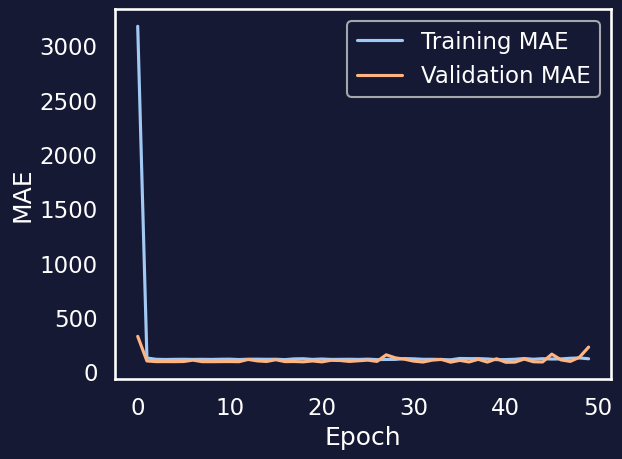

13/13 [==============================] - 0s 2ms/step - loss: 96998.0234 - mae: 265.7126
Test Mean Absolute Error: 265.71258544921875


{'mae': 265.7126,
 'mse': 96998.04,
 'rmse': 311.44507,
 'mape': 1.5288678,
 'mase': 2.1104922}

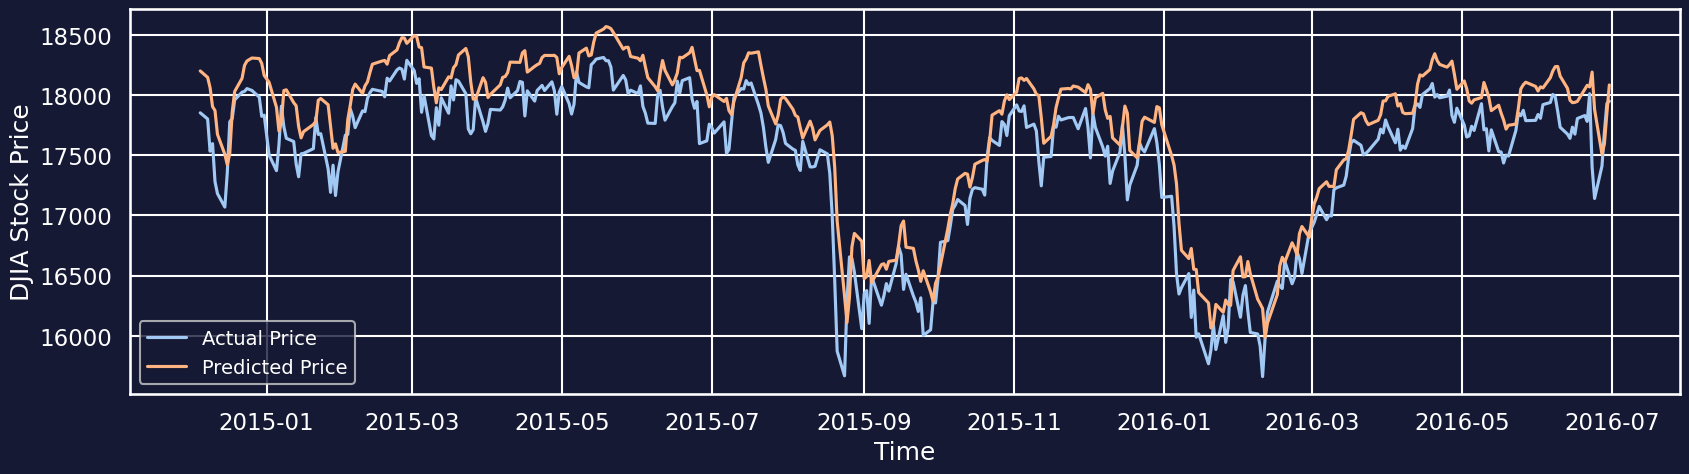

In [30]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam


# Assuming you have numerical features (x_train, x_test) and labels (y_train, y_test)

# Define the model
model = Sequential()
model.add(Dense(512, activation='relu', input_dim=x_train.shape[1]))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))  # Use linear activation for regression


learning_rate = 0.0001
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='mean_squared_error',
              metrics=['mae'])

#model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])  # Use appropriate metrics for regression

# Train the model
history = model.fit(x_train, y_train, epochs=50, batch_size=16, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(x_test, y_test)
print(f'Test Mean Absolute Error: {test_mae}')

# Plot training history (optional)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

# Make predictions on the test set
predictions = model.predict(x_test).flatten()

model.evaluate(x_test,y_test)

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(x_test, y_test)
print(f'Test Mean Absolute Error: {test_mae}')

X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

# Plot future price predictions of sts
plt.figure(figsize=(20, 5))
plot_time_series(y_test.index, y_test, format="-", label="Actual Price")
plot_time_series(y_test.index, predictions, format="-", label="Predicted Price")

# Flatten y_test
y_test_flat = y_test.to_numpy().flatten()


# Evaluate the model's predictions
model_results = evaluate_preds(y_true=y_test_flat, y_pred=predictions)
model_results

13/13 [==============================] - 0s 2ms/step - loss: 31686.0352 - mae: 133.6052
Test Mean Absolute Error: 133.605224609375


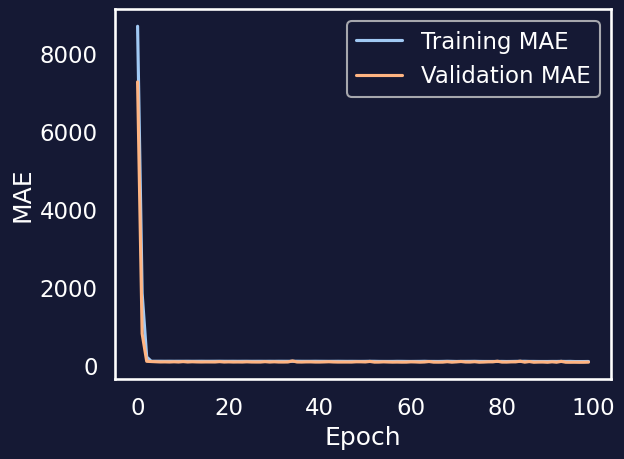

13/13 [==============================] - 0s 2ms/step - loss: 31686.0352 - mae: 133.6052
Test Mean Absolute Error: 133.605224609375


{'mae': 133.60524,
 'mse': 31686.037,
 'rmse': 178.00572,
 'mape': 0.7743997,
 'mase': 1.0611948}

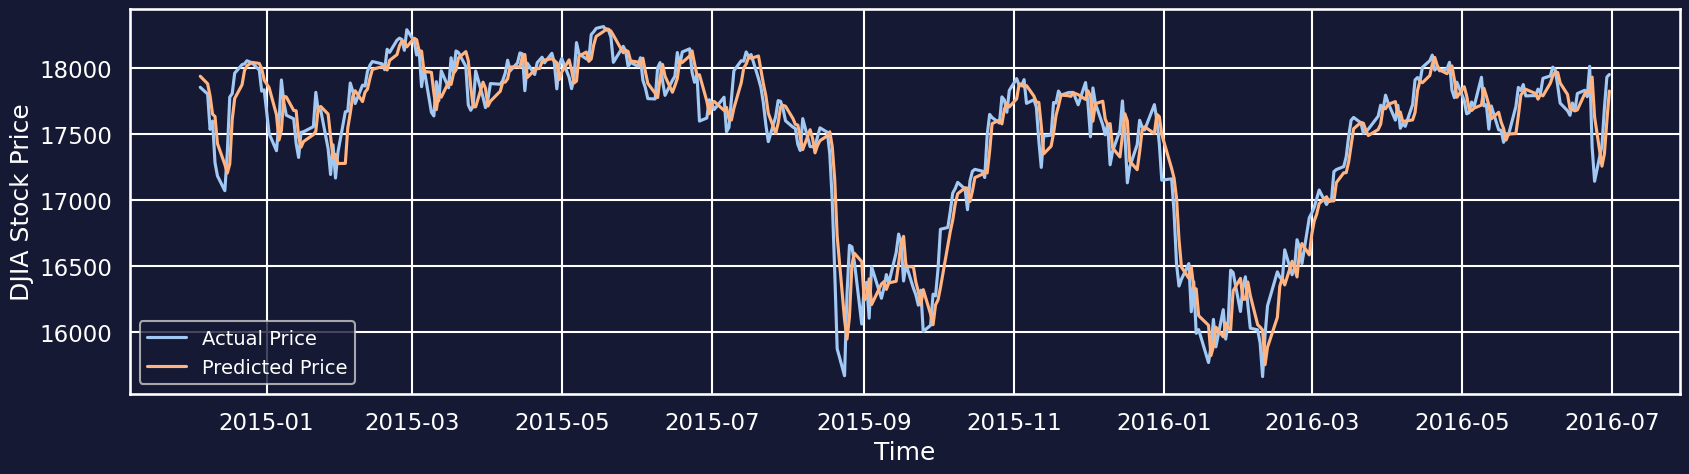

In [31]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

# Define the model
model = Sequential()
model.add(Dense(512, activation='relu', input_dim=x_train.shape[1]))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))  # Use linear activation for regression

# Adjusted learning rate
learning_rate = 0.0001

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='mean_squared_error',
              metrics=['mae'])

# Train the model
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(x_test, y_test)
print(f'Test Mean Absolute Error: {test_mae}')

# Plot training history (optional)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

# Make predictions on the test set
predictions = model.predict(x_test).flatten()

model.evaluate(x_test,y_test)

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(x_test, y_test)
print(f'Test Mean Absolute Error: {test_mae}')

X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

# Plot future price predictions of sts
plt.figure(figsize=(20, 5))
plot_time_series(y_test.index, y_test, format="-", label="Actual Price")
plot_time_series(y_test.index, predictions, format="-", label="Predicted Price")

# Flatten y_test
y_test_flat = y_test.to_numpy().flatten()

# Evaluate the model's predictions
model_results = evaluate_preds(y_true=y_test_flat, y_pred=predictions)
model_results

In [32]:
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(1580, 1580, 395, 395)

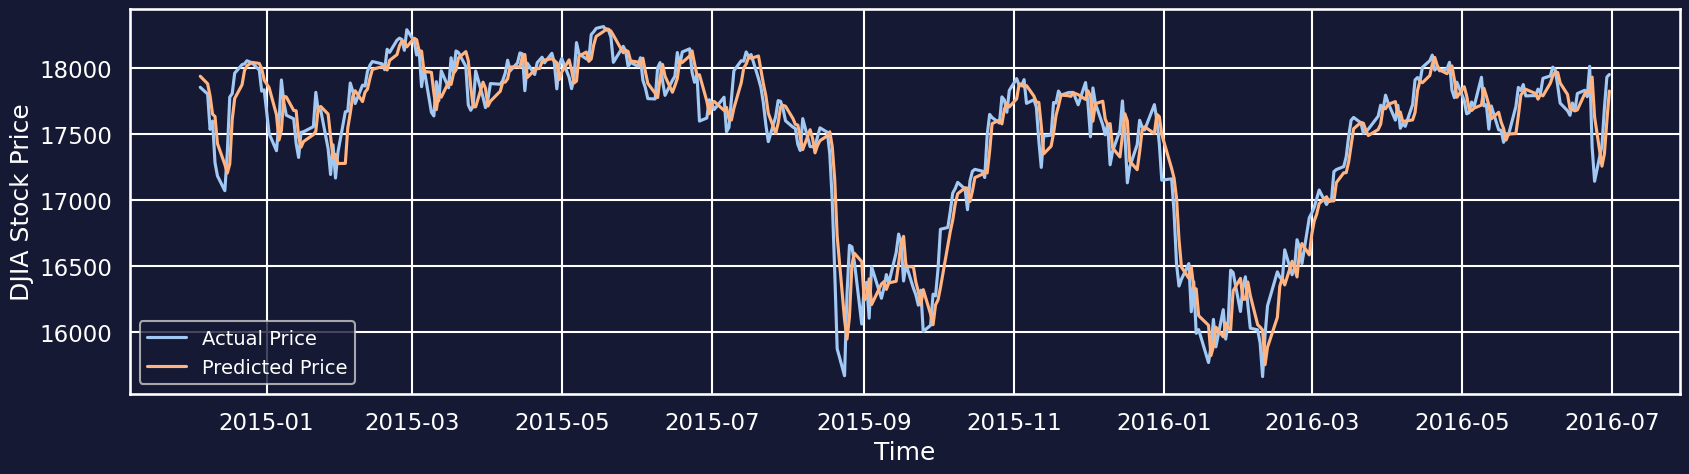

In [33]:

# Plot future price predictions of sts
plt.figure(figsize=(20, 5))
plot_time_series(y_test.index, y_test, format="-", label="Actual Price")
plot_time_series(y_test.index, predictions, format="-", label="Predicted Price")

In [34]:
# Evaluate the model's predictions
Keras_Sequential_Model_results = evaluate_preds(y_true=y_test_flat, y_pred=predictions)
Keras_Sequential_Model_results

{'mae': 133.60524,
 'mse': 31686.037,
 'rmse': 178.00572,
 'mape': 0.7743997,
 'mase': 1.0611948}

In [35]:
# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"naive_model": naive_results,
                              "Keras_Sequential_results": Keras_Sequential_Model_results}).T
model_results

,mae,mse,rmse,mape,mase
naive_model,125.681572,27671.523438,166.347595,0.728094,0.998652
Keras_Sequential_results,133.605240,31686.037109,178.005722,0.774400,1.061195


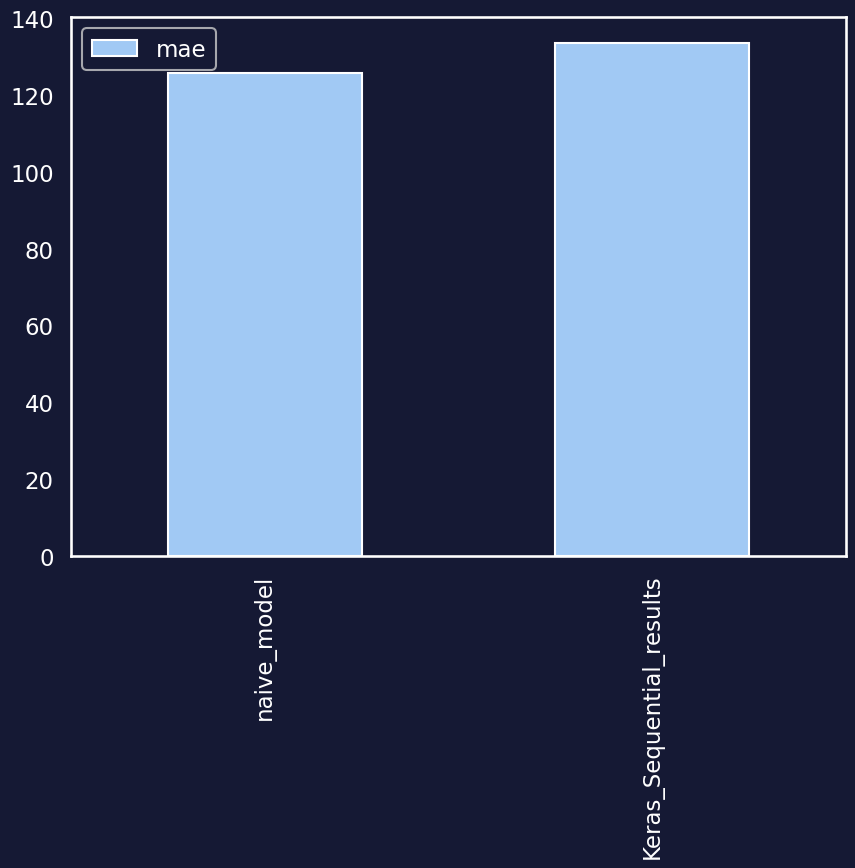

In [36]:
# Sort model results by MAE and plot them
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar");

In [37]:
bitcoin_prices_windowed

,Open,High,Low,Close,EMA,MA7,Close+1,Close Price
Date,,,,,,,,
2008-08-27,11412.459961,11554.459961,11381.769531,11502.509766,11476.097660,11446.554130,11412.870117,11715.179688
2008-08-28,11499.870117,11715.179688,11499.790039,11715.179688,11635.493777,11498.929827,11502.509766,11543.959961
2008-08-29,11713.230469,11713.230469,11543.389648,11543.959961,11574.470199,11517.005580,11715.179688,11516.919922
2008-09-02,11545.629883,11790.169922,11471.900391,11516.919922,11536.103131,11529.392718,11543.959961,11532.879883
2008-09-03,11506.009766,11554.379883,11416.530273,11532.879883,11533.954295,11515.795620,11516.919922,11188.230469
...,...,...,...,...,...,...,...,...
2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,17286.702282,17663.235770,17400.750000,17409.720703
2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,17368.714563,17625.315848,17140.240234,17694.679688
2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,17586.024646,17609.574498,17409.720703,17929.990234


In [38]:
# Convert data to integers
X_all = bitcoin_prices_windowed.drop(["Close Price"], axis=1).dropna().to_numpy().astype(int)
y_all = bitcoin_prices_windowed.dropna()["Close Price"].to_numpy().astype(int)

# Turn X and y into tensor Datasets
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# Combine features & labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# Batch and prefetch for optimal performance
BATCH_SIZE = 16
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [39]:
X_all

array([[11412, 11554, 11381, ..., 11476, 11446, 11412],
       [11499, 11715, 11499, ..., 11635, 11498, 11502],
       [11713, 11713, 11543, ..., 11574, 11517, 11715],
       ...,
       [17456, 17704, 17456, ..., 17586, 17609, 17409],
       [17712, 17930, 17711, ..., 17815, 17623, 17694],
       [17924, 18002, 17916, ..., 17904, 17647, 17929]])

In [40]:
last_window = X_all[-1:]
last_window.shape[1]

7

In [41]:
# How many timesteps to predict into the future?
INTO_FUTURE = 1 # since our Bitcoin data is daily, this is for 14 days

In [42]:
future_forecast = []
last_window = X_all[-1:]

In [43]:
last_window

array([[17924, 18002, 17916, 17949, 17904, 17647, 17929]])

# CNN

In [44]:

split_size = int(len(X) * 0.8)

X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(1580, 1580, 395, 395)

13/13 [==============================] - 0s 26ms/step - loss: 31142.0234 - mae: 130.5054
Test Mean Absolute Error: 130.50540161132812


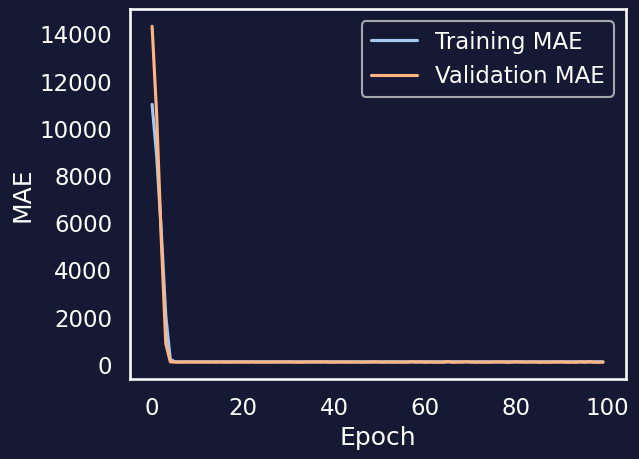

13/13 [==============================] - 0s 2ms/step


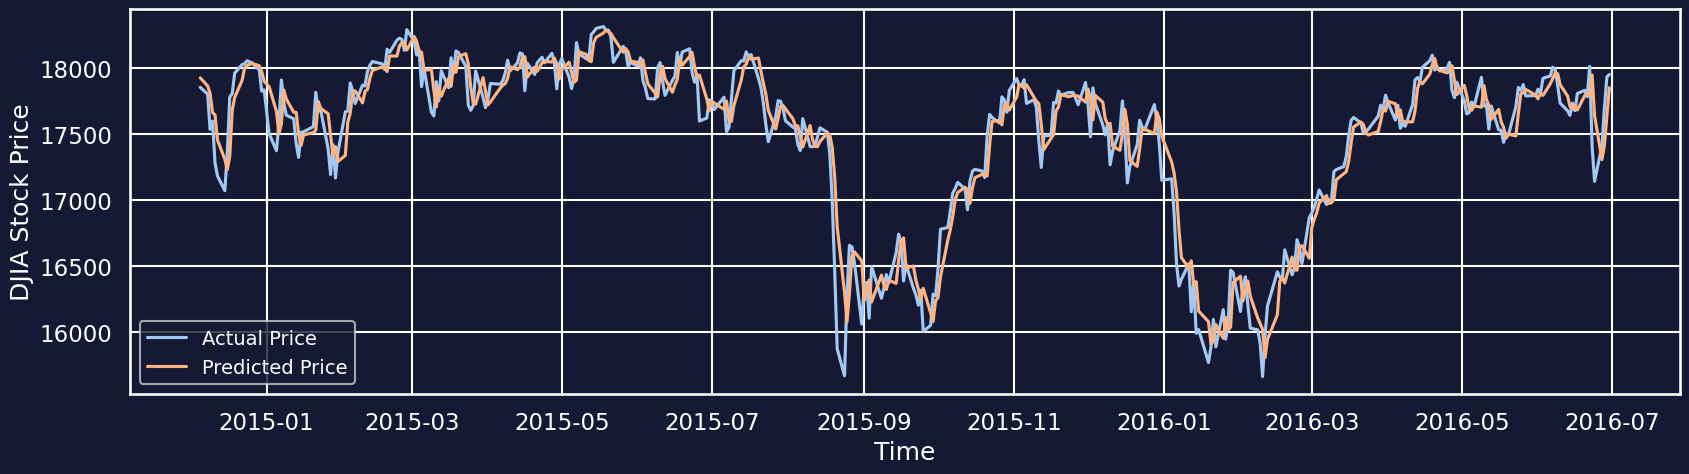

In [45]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

# Assuming x_train, y_train, x_test, and y_test are prepared as per the instructions

# Align the indices of x_train and y_train
min_samples_train = min(len(x_train), len(y_train))
x_train_aligned = x_train[:min_samples_train]
y_train_aligned = y_train[:min_samples_train]

# Align the indices of x_test and y_test
min_samples_test = min(len(x_test), len(y_test))
x_test_aligned = x_test[:min_samples_test]
y_test_aligned = y_test[:min_samples_test]

# Reshape the input data for CNN
x_train_reshaped = x_train_aligned.reshape((x_train_aligned.shape[0], x_train_aligned.shape[1], 1))
x_test_reshaped = x_test_aligned.reshape((x_test_aligned.shape[0], x_test_aligned.shape[1], 1))

# Define the CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train_aligned.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

# Adjusted learning rate
learning_rate = 0.0001

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='mean_squared_error',
              metrics=['mae'])

# Train the model
history = model.fit(x_train_reshaped, y_train_aligned, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(x_test_reshaped, y_test_aligned)
print(f'Test Mean Absolute Error: {test_mae}')

# Plot training history (optional)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

# Make predictions on the test set
predictions = model.predict(x_test_reshaped)

# Ensure predictions and true values are 1-dimensional arrays
predictions = predictions.flatten()
y_test_aligned_flat = y_test_aligned[:len(predictions)].to_numpy().flatten()

# Plot future price predictions
plt.figure(figsize=(20, 5))
plot_time_series(y_test_aligned.index[:len(predictions)], y_test_aligned_flat, format="-", label="Actual Price")
plot_time_series(y_test_aligned.index[:len(predictions)], predictions, format="-", label="Predicted Price")

In [46]:
# Evaluate the model's predictions
CNN_model_results = evaluate_preds(y_true=y_test_aligned_flat, y_pred=predictions)
CNN_model_results

{'mae': 130.50539,
 'mse': 31142.02,
 'rmse': 176.47101,
 'mape': 0.7569835,
 'mase': 1.0365734}

In [55]:
# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"naive_model": naive_results,
                              "Keras_Sequential_results": Keras_Sequential_Model_results,
                              "CNN_results": CNN_model_results}).T
model_results

,mae,mse,rmse,mape,mase
naive_model,125.681572,27671.523438,166.347595,0.728094,0.998652
Keras_Sequential_results,133.605240,31686.037109,178.005722,0.774400,1.061195
CNN_results,130.505386,31142.019531,176.471008,0.756984,1.036573


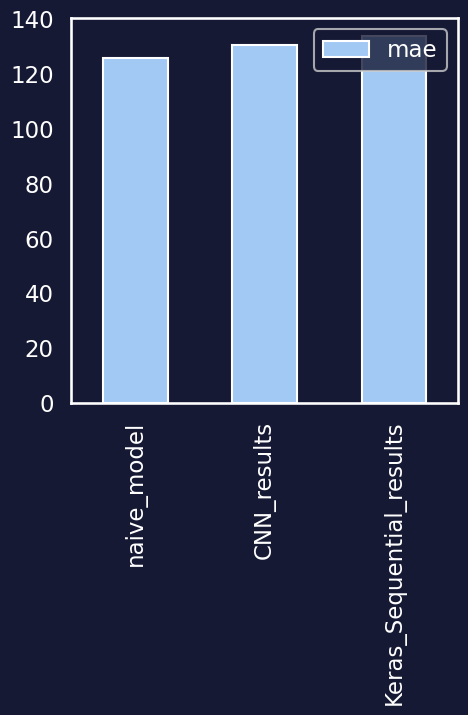

In [57]:
# Sort model results by MAE and plot them
model_results[["mae"]].sort_values(by="mae").plot(figsize=(5, 5), kind="bar");